In [1]:
from pflow.particle_filter import BootstrapFilter, ObservationBase, FilterState, LikelihoodMethodBase, ProposalMethodBase
from pflow.base import BaseReweight
from pflow.optimal_transport.transportation_plan import Transport
from pflow.resampling.systematic import SystematicResampling
from pflow.optimal_transport.recentering import LearnBest, IncrementalLearning
from joblib import Parallel, delayed


In [2]:
import pykalman
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
class BrownianProposalMethod(ProposalMethodBase):
    def __init__(self, transition, lower_triang_chol):
        self.transition = transition
        locs = torch.zeros(lower_triang_chol.shape[0], requires_grad=False)
        self._dist = torch.distributions.MultivariateNormal(locs, scale_tril=lower_triang_chol)
        
    def apply(self, state, _observation):
        x = state.x
        sample = self._dist.rsample((x.shape[0],))
        x_proposed = ((self.transition @ state.x.T).T + sample)
        return FilterState(x=x_proposed, logw=state.logw, n=state.n, loglik=state.loglik)
    
class Observation(ObservationBase):
    __slots__ = ['y']
    def __init__(self, y):
        self.y = y
        
class LikelihoodMethod(LikelihoodMethodBase):
    def __init__(self, obs_matrix, obs_cov_triang):
        locs = torch.zeros(obs_cov_triang.shape[0], requires_grad=False)
        self._obs_matrix = obs_matrix
        self._dist = torch.distributions.MultivariateNormal(loc=locs, scale_tril=obs_cov_triang)
        
    def apply(self, state, observation, log=True):
        distance = (self._obs_matrix @ state.x.T).T - observation.y.unsqueeze(0)
        log_probs = self._dist.log_prob(distance)
        if log:
            return log_probs
        else:
            return log_probs.exp()
        
class NoResampling(BaseReweight):
    def apply(self, x, w, logw):
        return x, logw

In [4]:
_ = torch.random.manual_seed(0)

In [5]:
import math
import random
random.seed(42)

In [6]:
def autoregressive(factor, noise, error, seed=42):
    random.seed(seed)
    x = random.gauss(0., 1.)
    while True:
        x = factor * x + noise * random.gauss(0., 1.)
        yield x + error * random.gauss(0., 1.)
    

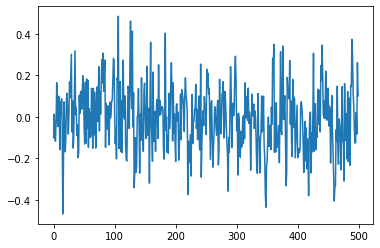

In [7]:
K = 500

autoregressive_gen = autoregressive(0.5, 0.1, 0.1)
ar = [[next(autoregressive_gen)] for _ in range(K)]
observations = np.asanyarray(ar).astype(np.float32)
plt.plot(observations)

In [8]:
def ar_pf(values, phi, log_noise, log_error, epsilon=0.5, n=100, seed=0, scaling=0.75, reach=None, min_neff=0.5, reweighting_method=None):
    states = []
    observations = []
    
    torch.random.manual_seed(seed)
    
    initial_dist = torch.distributions.MultivariateNormal(torch.tensor([0.]), scale_tril=torch.tensor([[1.]]))
    initial_x = initial_dist.rsample((n,)).clone()
    initial_x.requires_grad=True
    initial_w = torch.full((n,), 1/n, requires_grad=True)
    initial_log_lik = torch.tensor(0., requires_grad=True)
    
    lower = torch.eye(1, requires_grad=False)  * torch.exp(log_noise / 2.)
    transition_matrix = torch.eye(1, requires_grad=False) * phi
    obs_matrix = torch.tensor([[1.]], requires_grad=False)
    obs_triang = torch.eye(1, requires_grad=False) * torch.exp(log_error/2.)
    state = FilterState(x=initial_x, logw=initial_w.log(), n=n, loglik=initial_log_lik)
    likelihood_method = LikelihoodMethod(obs_matrix, obs_triang)
    if reweighting_method is None:
        if epsilon > 0:
            reweighting_method = Transport(epsilon=epsilon, scaling=scaling, reach=reach)
        else:
            reweighting_method = SystematicResampling()
    boot = BootstrapFilter(proposal_method=BrownianProposalMethod(transition_matrix, lower),
                           likelihood_method=likelihood_method, 
                           reweighting_method=reweighting_method,
                           min_neff=min_neff)
    n_obs = 0
    for val in values:
        n_obs += 1
        obs = Observation(torch.tensor(val, requires_grad=False))
        state = boot.update(state, obs)
        observations.append(obs)
        states.append(state)
        
        state = boot.predict(state, None)
    return -state.loglik / n_obs, states, observations

In [9]:
log_error = torch.tensor(math.log(0.01), requires_grad=True)
log_noise = torch.tensor(math.log(0.01), requires_grad=True)
phi       = torch.tensor(0.5, requires_grad=True)


In [10]:
%time ar_systematic = ar_pf(observations, phi, log_noise, log_error, 0., n=100, min_neff=0.5)
%time ar_10 = ar_pf(observations, phi, log_noise, log_error, 0.1, n=100, scaling=0.75, min_neff=0.5, reach=5.)
%time ar_100 = ar_pf(observations, phi, log_noise, log_error, 1., n=100, scaling=0.75, min_neff=0.5, reach=5.)


Wall time: 360 ms
Wall time: 2.04 s
Wall time: 718 ms


In [11]:
kf = pykalman.KalmanFilter(observation_covariance=[[0.01]], 
                           transition_covariance=[[0.01]], 
                            transition_matrices=[[0.5]], 
                            initial_state_mean=[0.])
kf_eps = pykalman.KalmanFilter(observation_covariance=[[0.01]], 
                           transition_covariance=[[0.01]], 
                            transition_matrices=[[0.5 + 1e-4]], 
                            initial_state_mean=[0.])
ar_kf = kf.filter(observations)

ll = -kf.loglikelihood(observations)/K
ll_eps = -kf_eps.loglikelihood(observations)/K

(ll_eps - ll)*1e4

-0.002041849320177924

In [12]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights, axis=0)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights, axis=0)
    return (average, np.sqrt(variance))

In [13]:
def plot_pf_component(pf_res, linspace, component, ax, label, show=None):
    pf_state, pf_weight = zip(*[(l.x.detach().cpu().numpy(),  l.w.detach().cpu().numpy()) for l in pf_res[1]])
    pf_weight = np.stack(pf_weight, axis=0)
    pf_state = np.stack(pf_state, axis=0)

    pf_mean, pf_std = weighted_avg_and_std(pf_state[:, :, component].T,  pf_weight.T)
    ax.plot(linspace[: show], pf_mean[: show], label = label)
    ax.fill_between(linspace[: show], 
                    pf_mean[: show] - 2 * pf_std[: show],
                    pf_mean[: show] + 2 * pf_std[: show], alpha = 0.3)
    

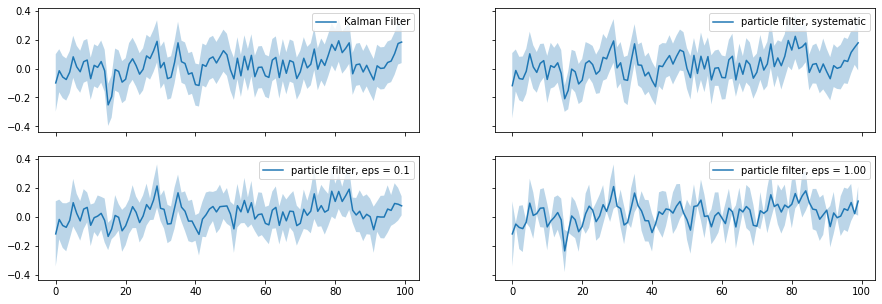

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5), sharex=True, sharey=True)

show = 100
linspace = np.arange(0, K)

axes[0, 0].plot(linspace[: show], ar_kf[0][:, 0].squeeze()[: show], label='Kalman Filter')
axes[0, 0].fill_between(linspace[: show], 
                     ar_kf[0][:, 0].squeeze()[: show] - 2*np.sqrt(ar_kf[1][:, 0, 0])[: show],
                     ar_kf[0][:, 0].squeeze()[: show] + 2*np.sqrt(ar_kf[1][:, 0, 0])[: show], alpha = 0.3)


plot_pf_component(ar_10, linspace, 0, axes[1, 0], 'particle filter, eps = 0.1', show)
plot_pf_component(ar_100, linspace, 0, axes[1, 1], 'particle filter, eps = 1.00', show)
plot_pf_component(ar_systematic, linspace, 0, axes[0, 1], 'particle filter, systematic', show)


for ax in axes.flatten():
    ax.legend(loc='upper right')

# axes[0].set_title('AR(1)')

fig.savefig('AR_PF_optimalTransport.png')

In [15]:
linspace = np.linspace(0.25, 0.75, 250)
epsilons = [0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.75, 1.]

In [16]:
results_for_smoothness_ot_dict = {}
results_for_smoothness_ot_grad_dict = {}
for eps in epsilons:
    results_for_smoothness_ot_dict[eps] = []
    results_for_smoothness_ot_grad_dict[eps] = []
    for val in tqdm.tqdm(linspace):
        phi_tensor = torch.tensor(val, requires_grad=True)
        temp_res = ar_pf(observations, phi_tensor, log_noise, log_error, eps, n=100, scaling=0.9, min_neff=0.5, reach=None)
#         temp_res = run_pf(flat, log_sigma_val, dt_tensor, eps, n=100, scaling=0.9, min_neff=0.5, reach=5.)
        results_for_smoothness_ot_grad_dict[eps].append(torch.autograd.grad(temp_res[0], phi_tensor)[0].detach().cpu().numpy())
        results_for_smoothness_ot_dict[eps].append(temp_res[0].detach().cpu().numpy())
    


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [04:32<00:00,  1.09s/it]


In [17]:
results_for_smoothness_systematic_dict = {}
results_for_smoothness_systematic_grad_dict = {}
for n in [100]:
    results_for_smoothness_systematic_dict[n] = []
    results_for_smoothness_systematic_grad_dict[n] = []
    for val in tqdm.tqdm(linspace):
        phi_tensor = torch.tensor(val, requires_grad=True)
        temp_res = ar_pf(observations, phi_tensor, log_noise, log_error, 0., n=100, min_neff=0.5)
        results_for_smoothness_systematic_grad_dict[n].append(torch.autograd.grad(temp_res[0], phi_tensor)[0].detach().cpu().numpy())
        results_for_smoothness_systematic_dict[n].append(temp_res[0].detach().cpu().numpy())


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [02:28<00:00,  1.69it/s]


In [18]:
# results_for_learnt_ot_dict = {}
# eps = 0.1
# adam_kwargs = {'lr': 0.5}
# methods = {#'incremental': IncrementalLearning(eps, {'scaling': 0.5}, adam_kwargs, 4, 5),
#            'one-shot': LearnBest(eps, {'scaling': 0.75}, adam_kwargs, 10)}
# for name, method in methods.items():
#     results_for_learnt_ot_dict[name] = [~]
#     for val in tqdm.tqdm(linspace):
#         log_sigma_tensor = torch.tensor(val, requires_grad=False)
#         temp_res = run_pf(flat, log_sigma_tensor, dt_tensor, eps, n=250, reweighting_method=method)
#         results_for_learnt_ot_dict[name].append(temp_res[0].detach().cpu().numpy())


In [19]:
results_for_kalman = []
grads_for_kalman = []
for val in tqdm.tqdm(linspace):
    kf = pykalman.KalmanFilter(observation_covariance=[[0.01]], 
                               transition_covariance=[[0.01]], 
                               transition_matrices=[[val]], 
                               initial_state_mean=[0.])
    kf_eps = pykalman.KalmanFilter(observation_covariance=[[0.01]], 
                                   transition_covariance=[[0.01]], 
                                   transition_matrices=[[val + 1e-4]], 
                                   initial_state_mean=[0.])
    ll = -kf.loglikelihood(observations)/len(observations)
    ll_eps = -kf_eps.loglikelihood(observations)/len(observations)
    results_for_kalman.append(ll)
    grads_for_kalman.append(1e4*(ll_eps-ll))

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [02:26<00:00,  1.68it/s]


In [20]:
def plot_gradient(linspace, values, gradients, k, ax, line):
    x = np.take(linspace, k)
    y = np.take(values, k)
    v = np.take(gradients, k)
    u = [1]*len(k)
    ax.quiver(x, y, u, v, scale=20, zorder=3, color=l.get_color(),
          width=0.007, headwidth=3., headlength=4.)

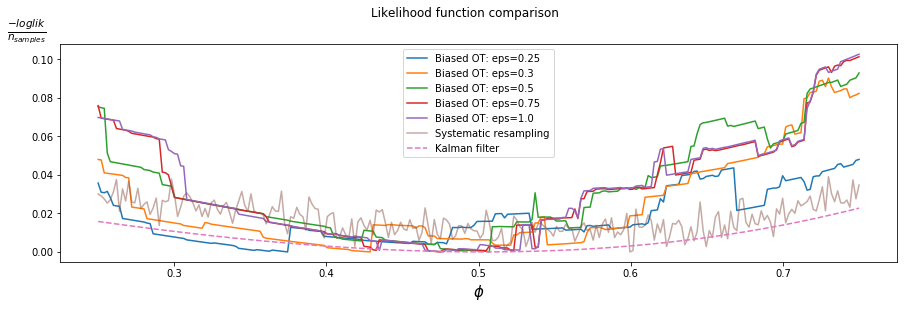

In [21]:
fig, ax = plt.subplots(ncols=1, figsize=(15, 4), sharey=False, sharex=False)
fig.suptitle('Likelihood function comparison', y = 1.01)

for eps, lst in results_for_smoothness_ot_dict.items():
    if eps >= 0.25:
        arr = np.asanyarray(lst)
        ax.plot(linspace, arr - arr.min(), label=f'Biased OT: eps={eps}')
arr_sys = np.asanyarray(results_for_smoothness_systematic_dict[100])
ax.plot(linspace, arr_sys - arr_sys.min(), label=f'Systematic resampling', alpha=0.5)

arr_kf = np.asanyarray(results_for_kalman)
ax.plot(linspace, arr_kf - arr_kf.min(), label = 'Kalman filter', linestyle = '--')

# zoom = slice(0, 250)
# grads_locs =  [25, 100, 175]
# for eps, lst in results_for_smoothness_ot_dict.items():
#     l, = axes[1].plot(linspace[zoom], lst[zoom], label=f'Biased OT: eps={eps}')
#     plot_gradient(linspace, lst, results_for_smoothness_ot_grad_dict[eps], grads_locs, axes[1], l)

# l, = axes[1].plot(linspace[zoom], results_for_smoothness_systematic_dict[100][zoom], label=f'Systematic resampling', alpha=0.5)
# plot_gradient(linspace, results_for_smoothness_systematic_dict[100], results_for_smoothness_systematic_grad_dict[100], grads_locs, axes[1], l)

# axes[1].plot(linspace[zoom], results_for_kalman[zoom], label = 'Kalman filter', linestyle = '--')

# for ax in axes.flatten():
ax.set_ylabel('$\\frac{-loglik}{n_{samples}}$', rotation=0, y=1, fontsize=15)
ax.set_xlabel('$\phi$', rotation=0, y=1, fontsize=15)
    
ax.legend()
    
fig.savefig('ar_likelihood.png')

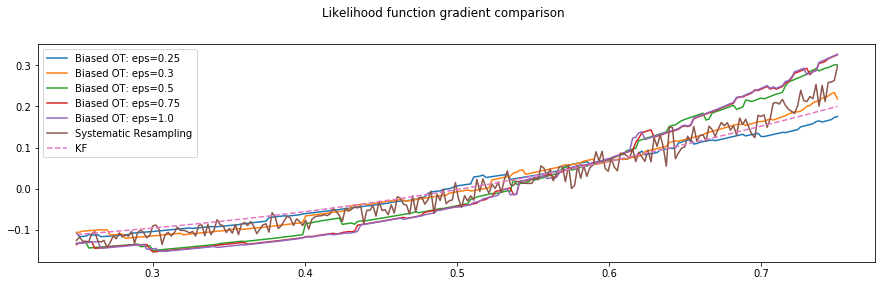

In [60]:
fig, ax = plt.subplots(figsize=(15, 4), sharey=False, sharex=True)
fig.suptitle('Likelihood function gradient comparison', y = 1.01)
for eps, grads in results_for_smoothness_ot_grad_dict.items():
    if eps >= 0.25:
        ax.plot(linspace, np.stack(grads), label = f'Biased OT: eps={eps}')
    
ax.plot(linspace, np.stack(results_for_smoothness_systematic_grad_dict[100]), label='Systematic Resampling')
ax.plot(linspace, np.stack(grads_for_kalman), label='KF', linestyle='--')

ax.legend()
fig.savefig('ar_likelihoodGradient.png')

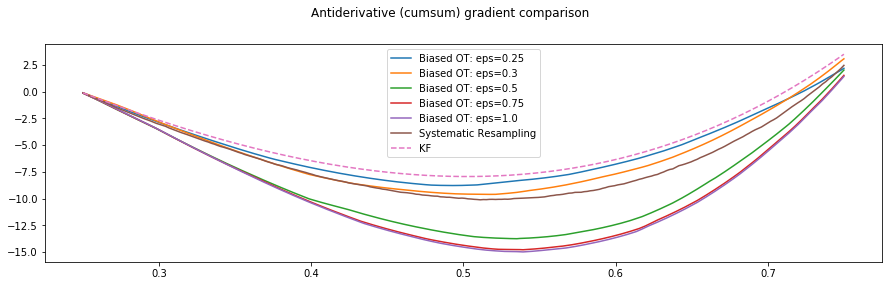

In [62]:
fig, ax = plt.subplots(figsize=(15, 4), sharey=False, sharex=True)
fig.suptitle('Antiderivative (cumsum) gradient comparison', y = 1.01)
for eps, grads in results_for_smoothness_ot_grad_dict.items():
    if eps >= 0.25:
        ax.plot(linspace, np.cumsum(np.stack(grads)), label = f'Biased OT: eps={eps}')
    
ax.plot(linspace, np.cumsum(np.stack(results_for_smoothness_systematic_grad_dict[100])), label='Systematic Resampling')
ax.plot(linspace, np.cumsum(np.stack(grads_for_kalman)), label='KF', linestyle='--')

ax.legend()
fig.savefig('ar_likelihoodGradient.png')

In [57]:
n_iter = 50
lr = 1.
phi_tensor = torch.tensor(0.25, requires_grad=True)
phi_tensors_ot = [phi_tensor.detach().cpu().numpy().sum()]
for _ in tqdm.trange(n_iter):
    temp_res = ar_pf(observations, phi_tensor, log_noise, log_error, 0.25, n=100, scaling=0.5, min_neff=0.5, reach=None)
    grad = torch.autograd.grad(temp_res[0], phi_tensor)
    phi_tensor.data -= lr * grad[0]
    phi_tensors_ot.append(phi_tensor.detach().cpu().numpy().sum())
phi_tensor

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.24s/it]


tensor(0.4945, requires_grad=True)

In [58]:
n_iter = 50
lr = 1.
phi_tensor = torch.tensor(0.25, requires_grad=True)
phi_tensors_sys = [phi_tensor.detach().cpu().numpy().sum()]

for _ in tqdm.trange(n_iter):
    temp_res = ar_pf(observations, phi_tensor, log_noise, log_error, 0., n=100, min_neff=0.5, reach=None)
    grad = torch.autograd.grad(temp_res[0], phi_tensor)
    phi_tensor.data -= lr * grad[0]
    phi_tensors_sys.append(phi_tensor.detach().cpu().numpy().sum())

phi_tensor

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.72it/s]


tensor(0.5084, requires_grad=True)

In [59]:
n_iter = 50
lr = 1.
phi_val = 0.25
phi_tensors_kf = [phi_val]

for _ in tqdm.trange(n_iter):
    kf = pykalman.KalmanFilter(observation_covariance=[[0.01]], 
                               transition_covariance=[[0.01]], 
                               transition_matrices=[[phi_val]], 
                               initial_state_mean=[0.])
    kf_eps = pykalman.KalmanFilter(observation_covariance=[[0.01]], 
                                   transition_covariance=[[0.01]], 
                                   transition_matrices=[[phi_val + 1e-4]], 
                                   initial_state_mean=[0.])
    
    ll = -kf.loglikelihood(observations)/len(observations)
    ll_eps = -kf_eps.loglikelihood(observations)/len(observations)
    
    grad = (ll_eps - ll)*1e4
    phi_val -= lr * grad
    phi_tensors_kf.append(phi_val)



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.58it/s]


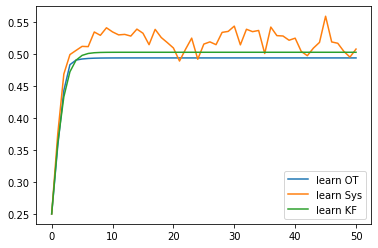

In [61]:
plt.plot(phi_tensors_ot, label = 'learn OT')
plt.plot(phi_tensors_sys, label = 'learn Sys')
plt.plot(phi_tensors_kf, label = 'learn KF')
plt.legend()